### Initialization

In [0]:
%pip install sentence-transformers
%pip install torch

Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
from pyspark.sql.types import *
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, when, expr, add_months
from pyspark.sql.window import Window
spark = SparkSession.builder.getOrCreate()
import matplotlib.pyplot as plt

import re
import numpy as np
from datetime import datetime, timedelta
import copy
import pandas as pd
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random

In [0]:
profiles = spark.read.parquet('/linkedin/people')
companies = spark.read.parquet('/linkedin/companies')

profiles_original_size = profiles.count()
companies_original_size = companies.count()

print("initial data:")
print("    * number of users: ", profiles_original_size)
print("    * number of companies: ", companies_original_size)

initial data:
    * number of users:  3462290
    * number of companies:  1422797


### NLP model

In [0]:
from pyspark.sql.types import *
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import sparknlp
import pandas as pd
import numpy

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(768, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.bn = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, 31)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.bn(x)
        x = self.relu2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x


model1 = MyModel()
model1.load_state_dict(torch.load('/Workspace/Users/eilondagan@campus.technion.ac.il/model_weights.pth'))


from sentence_transformers import SentenceTransformer
from tqdm import tqdm

# Load pre-trained model
embedder = SentenceTransformer('paraphrase-distilroberta-base-v1')



# Function to embed sentences
def embed_sentences(sentences):
    embeddings = embedder.encode(sentences)
    return embeddings


data = [
    "AI",
    "Aerospace",
    "Construction",
    "Consumer",
    "Crypto",
    "Data",
    "Education",
    "Energy",
    "Finance",
    "Fitness",
    "Food",
    "HR",
    "Hardware",
    "Healthcare",
    "Infrastructure",
    "Legal",
    "Logistics",
    "Manufacturing",
    "Marketing",
    "Media",
    "Other",
    "Product",
    "Real Estate",
    "Recruiting",
    "Retail",
    "Sales",
    "Security",
    "Support",
    "Transportation",
    "Travel",
    "Unknown"
]
d = {i:meta for i,meta in enumerate(data)}
model1.eval()
def use_model(sentence):
    vec = torch.tensor(embed_sentences(sentence))

    output = model1.forward(vec.reshape(1,768))
   
    
    _, predicted = torch.max(output.data,1)
    ind =d[predicted.item()]
    return ind


print(use_model("some relevant string"))

Finance


# Data Analysis

### Year-Based Industries Data

In [0]:
path_layoffs = "/Workspace/Users/eilondagan@campus.technion.ac.il/layoffs.csv"
path_layoffs_3 = "/Workspace/Users/eilondagan@campus.technion.ac.il/layoffs_data(3).csv"

In [0]:
df = pd.read_csv(path_layoffs)
df["percentage_laid_off"].fillna(0,inplace=True)
df["funds_raised"].fillna(0,inplace=True)
df["date"] = df["date"].convert_dtypes(convert_string=True)
df['year'] = df['date'].apply(lambda x: int(x.split('-')[0]))

years = df["year"].unique()
dfs=[]
for year in years:
    dfs.append(df[df["year"]==year])

In [0]:
layoff_c_dict ={}
layoff_i_dict ={}
funds_c_dict ={}
funds_i_dict ={}

for i in range(1,len(years)):
    
    sum_per_company = dfs[i].groupby(['company', 'industry'])['percentage_laid_off'].agg(["sum", "std"]).reset_index()
    sum_per_company["std"].fillna(0,inplace=True)
    avg_per_category = sum_per_company.groupby(['industry'])['sum'].agg(['mean', 'std']).reset_index()
    avg_per_category["std"].fillna(0,inplace=True)
    
    layoff_c_dict[years[i]] = {
       
            company: (sum_value, std_value)
            for company, sum_value, std_value in zip(sum_per_company['company'], sum_per_company['sum'], sum_per_company['std'])
        }
    
    layoff_i_dict[years[i]]={
            company: (sum_value, std_value)
            for company, sum_value, std_value in zip(avg_per_category['industry'], avg_per_category['mean'], avg_per_category['std'])
        }
    
  

    funds_per_company = dfs[i].groupby(['company', 'industry'])['funds_raised'].agg(["sum", "std"]).reset_index()
    funds_per_company["std"].fillna(0,inplace=True)
    avgf_per_category = funds_per_company.groupby(['industry'])['sum'].agg(['mean', 'std']).reset_index()
    avgf_per_category["std"].fillna(0,inplace=True)

    funds_c_dict[years[i]] = {
       
            company: (sum_value, std_value)
            for company, sum_value, std_value in zip(funds_per_company['company'], funds_per_company['sum'], funds_per_company['std'])
        }
    
    funds_i_dict[years[i]]={
            company: (sum_value, std_value)
            for company, sum_value, std_value in zip(avgf_per_category['industry'], avgf_per_category['mean'], avgf_per_category['std'])
        }

In [0]:
df2 =pd.read_csv(path_layoffs_3)
df2["Percentage"].fillna(0,inplace=True)
df2["Funds_Raised"].fillna(0,inplace=True)
df2["Date"] = df2["Date"].convert_dtypes(convert_string=True)
df2['year'] = df2['Date'].apply(lambda x: int(x.split('-')[0]))
years = df2["year"].unique()
df2s=[]
for year in years:
    df2s.append(df2[df2["year"]==year])

In [0]:
layoff_c_dict2 ={}
layoff_i_dict2 ={}
funds_c_dict2 ={}
funds_i_dict2 ={}

for i in range(1,len(years)):
    
    sum_per_company = df2s[i].groupby(['Company', 'Industry'])['Percentage'].agg(["sum", "std"]).reset_index()
    sum_per_company["std"].fillna(0,inplace=True)
    avg_per_category = sum_per_company.groupby(['Industry'])['sum'].agg(['mean', 'std']).reset_index()
    avg_per_category["std"].fillna(0,inplace=True)
    
    layoff_c_dict2[years[i]] = {
       
            company: (sum_value, std_value)
            for company, sum_value, std_value in zip(sum_per_company['Company'], sum_per_company['sum'], sum_per_company['std'])
        }
    
    layoff_i_dict2[years[i]]={
            company: (sum_value, std_value)
            for company, sum_value, std_value in zip(avg_per_category['Industry'], avg_per_category['mean'], avg_per_category['std'])
        }
    
    
    funds_per_company = df2s[i].groupby(['Company', 'Industry'])['Funds_Raised'].agg(["sum", "std"]).reset_index()
    funds_per_company["std"].fillna(0,inplace=True)
    avgf_per_category = funds_per_company.groupby(['Industry'])['sum'].agg(['mean', 'std']).reset_index()
    avgf_per_category["std"].fillna(0,inplace=True)
    funds_c_dict2[years[i]] = {
       
            company: (sum_value, std_value)
            for company, sum_value, std_value in zip(funds_per_company['Company'], funds_per_company['sum'], funds_per_company['std'])
        }
    
    funds_i_dict2[years[i]]={
            company: (sum_value, std_value)
            for company, sum_value, std_value in zip(avgf_per_category['Industry'], avgf_per_category['mean'], avgf_per_category['std'])
        }

In [0]:
avg_i_layoff_vals = {2020: [], 2021: [], 2022: [], 2023: []}
avg_i_funds_vals = {2020: [], 2021: [], 2022: [], 2023: []}

for year in [2020, 2021, 2022, 2023]:
  tot_mean, tot_std = 0, 0
  counter = 0
  for key in  layoff_i_dict2[year]:
    mean, std = layoff_i_dict2[year][key]
    tot_mean += mean
    tot_std += std
    counter += 1
  avg_i_layoff_vals[year] = [tot_mean / counter, tot_std / counter]

for year in [2020, 2021, 2022, 2023]:
  tot_mean, tot_std = 0, 0
  counter = 0
  for key in  funds_i_dict2[year]:
    mean, std = funds_i_dict2[year][key]
    tot_mean += mean
    tot_std += std
    counter += 1
  avg_i_funds_vals[year] = [tot_mean / counter, tot_std / counter]

print('industries layoffs mean/std average')
print(avg_i_layoff_vals)
print()
print('industries funds mean/std average')
print(avg_i_funds_vals)

industries layoffs mean/std average
{2020: [0.20619836625802523, 0.26098933197440355], 2021: [0.3038888888888889, 0.14210148815249413], 2022: [0.20316824479417647, 0.2508246863514752], 2023: [0.18387350828582089, 0.2570462142727365]}

industries funds mean/std average
{2020: [420.7364636083245, 1237.8320987703908], 2021: [756.2472222222223, 812.0908321449971], 2022: [960.9664805453885, 3819.3012106737433], 2023: [567.4606591697263, 1269.5590292229847]}


In [0]:
avg_c_layoff_vals = {2020: [], 2021: [], 2022: [], 2023: []}
avg_c_funds_vals = {2020: [], 2021: [], 2022: [], 2023: []}

for year in [2020, 2021, 2022, 2023]:
  tot_mean, tot_std = 0, 0
  counter = 0
  for key in  layoff_c_dict2[year]:
    mean, std = layoff_c_dict2[year][key]
    tot_mean += mean
    tot_std += std
    counter += 1
  avg_c_layoff_vals[year] = [tot_mean / counter, tot_std / counter]

for year in [2020, 2021, 2022, 2023]:
  tot_mean, tot_std = 0, 0
  counter = 0
  for key in  funds_c_dict2[year]:
    mean, std = funds_c_dict2[year][key]
    tot_mean += mean
    tot_std += std
    counter += 1
  avg_c_funds_vals[year] = [tot_mean / counter, tot_std / counter]

print('companies layoffs mean/std average')
print(avg_c_layoff_vals)
print()
print('companies funds mean/std average')
print(avg_c_funds_vals)

companies layoffs mean/std average
{2020: [0.21578749999999994, 0.005419328652841721], 2021: [0.25534883720930235, 0.0], 2022: [0.19206103286384973, 0.013490211575772477], 2023: [0.20006711409395972, 0.009846424262391736]}

companies funds mean/std average
{2020: [540.2476591666666, 17.486825281709592], 2021: [924.9697674418604, 32.88868749704872], 2022: [1025.649765258216, 5.284031887034765], 2023: [675.2553691275168, 0.5823784336754331]}


In [0]:
# # Save dictionaries
# with open('layoff_industries.pickle', 'wb') as pickle_file:
#     pickle.dump(layoff_i_dict2, pickle_file)

# with open('funds_industries.pickle', 'wb') as pickle_file:
#     pickle.dump(funds_i_dict2, pickle_file)

In [0]:
all_industries = set()

for y in layoff_i_dict2:
    for k in layoff_i_dict2[y]:
        all_industries.add(k)
for y in funds_i_dict2:
    for k in funds_i_dict2[y]:
        all_industries.add(k)
print("all industries: ")
print(all_industries)

all industries: 
{'Fitness', 'Manufacturing', 'AI', 'Product', 'Construction', 'Marketing', 'Energy', 'Education', 'Other', 'Media', 'Data', 'Legal', 'Sales', 'Support', 'Unknown', 'Retail', 'Finance', 'Crypto', 'Security', 'Healthcare', 'Hardware', 'Aerospace', 'Travel', 'Recruiting', 'HR', 'Consumer', 'Infrastructure', 'Food', 'Real Estate', 'Transportation', 'Logistics'}


### Last Year Companies Data

In [0]:

# picking colums to fetsure by code
number_col=[]
# len languages ,education ,certifications ,posts , сourses
nullable_col =[]
uniquent_col =[]
# Loop through each column in the 'companies' DataFrame
nnull_count ={}
for column in companies.columns:
    # Count the number of non-null values in the column
    non_null_count = companies.filter(companies[column].isNotNull()).count()
    # Print the column name and count of non-null values
    #print(f"null count of {column}: {non_null_count}")
    nnull_count[column] =non_null_count
    if non_null_count >10000 and non_null_count <1200000: # between 10k and 2m
        nullable_col.append(column)
uni_count={}
# Loop through each column in the 'companies' DataFrame
for column in companies.columns:
    #print(companies.select(column).schema[0].dataType)
    if companies.select(column).schema[0].dataType != StringType():
        continue
    # Count the number of unique values in the column
    unique_count = companies.select(column).distinct().count()
    # Print the column name and number of unique values
    #print(f"uniquie count of {column}: {unique_count}")
    uni_count[column] = unique_count
    if nnull_count[column]  > 10000:
        if unique_count >2 and unique_count <1000:
            uniquent_col.append(column)

In [0]:
col_to_feature = uniquent_col
other_col = nullable_col
companies_features = companies
companies_features = companies
# Select all unique values in current_company:company_id from profiles DF
unique_company_ids = profiles.select("current_company.company_id").distinct().collect()
unique_company_ids_df = spark.createDataFrame([(id2.company_id,) for id2 in unique_company_ids], ['id2'])
# Join the unique_company_ids_df with companies_features DataFrame to filter based on the ids
filtered_df = companies_features.join(unique_company_ids_df, on=col('id') == col('id2')).drop("id2")

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
<command-3791678015593155> in <cell line: 9>()
      7 unique_company_ids_df = spark.createDataFrame([(id2.company_id,) for id2 in unique_company_ids], ['id2'])
      8 # Join the unique_company_ids_df with companies_features DataFrame to filter based on the ids
----> 9 filtered_df = companies_features.join(unique_company_ids_df, on=col('id') == col('id2')).drop("id2")

TypeError: 'str' object is not callable

In [0]:
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import concat_ws
from pyspark.ml.feature import OneHotEncoder
from pyspark.sql.functions import col, when

In [0]:
for coll in col_to_feature:
    # Replace 'column_name' with the actual name of the column
    companies_features = companies_features.withColumn(coll, companies_features[coll].cast("string"))
    indexer = StringIndexer(inputCol=str(coll), outputCol=coll+"_index", handleInvalid="skip")
    companies_features = indexer.fit(companies_features).transform(companies_features)
    #companies_features= companies_features.drop(coll ,coll+"_index")

for col_name in other_col:
    companies_features = companies_features.withColumn(col_name + "_is_null", when(col(col_name).isNull(), 1).otherwise(0))


In [0]:
# Get all column names in companies DataFrame
all_columns = companies.columns

# Remove column names in col_to_keep from all_columns
remaining_columns = [col for col in all_columns if col not in col_to_keep]

# Drop the old columns from companies_features DataFrame
companies_features = companies_features.drop(*remaining_columns)

In [0]:
# Create an empty dictionary
year_dict = {}

# Iterate over each row in the filtered_df DataFrame
for row in companies_features.collect():
    # Get the year from the timestamp column
    year = row['timestamp'][:4]
    
    # Get the company id
    company_id = row['id']
    
    # Get the vector of all other columns for the company
    vector = [row[column] for column in companies_features.columns if (column != 'id' and column != 'timestamp')]
    
    # Update the year_dict with the company id and vector
    if year not in year_dict:
        year_dict[year] = {}
    year_dict[year][company_id] = vector


In [0]:

# Generate Python code to create a dictionary where the 'id' column is the key and the 'industries' column is the value
meta_industries_12 = {
    'Furniture and Home Furnishings Manufacturing': 'Manufacturing',
    'Investment Banking': 'Financial and Investment',
    'Architecture and Planning': 'Services',
    'Wholesale': 'Services',
    'Travel Arrangements': 'Services',
    'Ranching': 'Miscellaneous',
    'Hospitals and Health Care': 'Healthcare and Medical',
    'Book and Periodical Publishing': 'Services',
    'Printing Services': 'Services',
    'Professional Training and Coaching': 'Services',
    'Computers and Electronics Manufacturing': 'Manufacturing',
    'Shipbuilding': 'Manufacturing',
    'Public Policy Offices': 'Government and Public Policy',
    'Software Development': 'Technology',
    'Outsourcing and Offshoring Consulting': 'Services',
    'Retail Groceries': 'Retail and Consumer Goods',
    'Education Administration Programs': 'Education and Training',
    'Plastics Manufacturing': 'Manufacturing',
    'Renewable Energy Semiconductor Manufacturing': 'Manufacturing',
    'Computer Networking Products': 'Technology',
    'Events Services': 'Services',
    'Information Services': 'Services',
    'Food and Beverage Services': 'Services',
    'Semiconductor Manufacturing': 'Manufacturing',
    'Business Consulting and Services': 'Services',
    'Insurance': 'Services',
    'Financial Services': 'Services',
    'Wireless Services': 'Services',
    'Computer Hardware Manufacturing': 'Technology',
    'Public Safety': 'Services',
    'Maritime Transportation': 'Transportation and Logistics',
    'Tobacco Manufacturing': 'Manufacturing',
    'Writing and Editing': 'Services',
    'Veterinary Services': 'Services',
    'Staffing and Recruiting': 'Services',
    'Accounting': 'Services',
    'International Affairs': 'Government and Public Policy',
    'Spectator Sports': 'Miscellaneous',
    'Glass, Ceramics and Concrete Manufacturing': 'Manufacturing',
    'Chemical Manufacturing': 'Manufacturing',
    'Mining': 'Miscellaneous',
    'E-Learning Providers': 'Technology',
    'Security and Investigations': 'Services',
    'Translation and Localization': 'Services',
    'Automation Machinery Manufacturing': 'Technology',
    'Computer and Network Security': 'Technology',
    'Political Organizations': 'Government and Public Policy',
    'Environmental Services': 'Government and Public Policy',
    'Oil and Gas': 'Miscellaneous',
    'Real Estate': 'Real Estate and Construction',
    'Think Tanks': 'Government and Public Policy',
    'Executive Offices': 'Miscellaneous',
    'Law Practice': 'Services',
    'Nanotechnology Research': 'Miscellaneous',
    'International Trade and Development': 'Government and Public Policy',
    'Personal Care Product Manufacturing': 'Manufacturing',
    'Philanthropic Fundraising Services': 'Services',
    'Entertainment Providers': 'Media and Entertainment',
    'Market Research': 'Media and Entertainment',
    'Movies, Videos, and Sound': 'Media and Entertainment',
    'Sporting Goods Manufacturing': 'Manufacturing',
    'Graphic Design': 'Services',
    'Technology, Information and Internet': 'Technology',
    'IT Services and IT Consulting': 'Technology',
    'Retail Office Equipment': 'Retail and Consumer Goods',
    'Wholesale Import and Export': 'Services',
    'Capital Markets': 'Financial and Investment',
    'Law Enforcement': 'Services',
    'Freight and Package Transportation': 'Transportation and Logistics',
    'Industrial Machinery Manufacturing': 'Manufacturing',
    'Non-profit Organizations': 'Miscellaneous',
    'Retail Art Supplies': 'Retail and Consumer Goods',
    'Animation and Post-production': 'Media and Entertainment',
    'Transportation, Logistics, Supply Chain and Storage': 'Transportation and Logistics',
    'Aviation and Aerospace Component Manufacturing': 'Transportation and Logistics',
    'Fundraising': 'Financial and Investment',
    'Railroad Equipment Manufacturing': 'Transportation and Logistics',
    'Construction': 'Real Estate and Construction',
    'Investment Management': 'Financial and Investment',
    'Utilities': 'Miscellaneous',
    'Retail Luxury Goods and Jewelry': 'Retail and Consumer Goods',
    'Warehousing and Storage': 'Transportation and Logistics',
    'Media Production': 'Media and Entertainment',
    'Gambling Facilities and Casinos': 'Media and Entertainment',
    'Defense and Space Manufacturing': 'Manufacturing',
    'Facilities Services': 'Services',
    'Government Relations Services': 'Government and Public Policy',
    'Advertising Services': 'Media and Entertainment',
    'Paper and Forest Product Manufacturing': 'Manufacturing',
    'Packaging and Containers Manufacturing': 'Manufacturing',
    'Telecommunications': 'Technology',
    'Medical Equipment Manufacturing': 'Healthcare and Medical',
    'Beverage Manufacturing': 'Manufacturing',
    'Restaurants': 'Retail and Consumer Goods',
    'Leasing Non-residential Real Estate': 'Real Estate and Construction',
    'Newspaper Publishing': 'Media and Entertainment',
    'Armed Forces': 'Miscellaneous',
    'Appliances, Electrical, and Electronics Manufacturing': 'Manufacturing',
    'Hospitality': 'Services',
    'Pharmaceutical Manufacturing': 'Healthcare and Medical',
    'Research Services': 'Services',
    'Retail Apparel and Fashion': 'Retail and Consumer Goods',
    'Photography': 'Media and Entertainment',
    'Wellness and Fitness Services': 'Services',
    'Truck Transportation': 'Transportation and Logistics',
    'Consumer Services': 'Services',
    'Wholesale Building Materials': 'Services',
    'Human Resources Services': 'Services',
    'Airlines and Aviation': 'Transportation and Logistics',
    'Machinery Manufacturing': 'Manufacturing',
    'Individual and Family Services': 'Services',
    'Motor Vehicle Manufacturing': 'Manufacturing',
    'Performing Arts': 'Media and Entertainment',
    'Museums, Historical Sites, and Zoos': 'Media and Entertainment',
    'Broadcast Media Production and Distribution': 'Media and Entertainment',
    'Banking': 'Financial and Investment',
    'Recreational Facilities': 'Miscellaneous',
    'Government Administration': 'Government and Public Policy',
    'Public Relations and Communications Services': 'Media and Entertainment',
    'Fisheries': 'Miscellaneous',
    'Medical Practices': 'Healthcare and Medical',
    'Religious Institutions': 'Miscellaneous',
    'Online Audio and Video Media': 'Media and Entertainment',
    'Artists and Writers': 'Miscellaneous',
    'Biotechnology Research': 'Healthcare and Medical',
    'Legal Services': 'Services',
    'Retail': 'Retail and Consumer Goods',
    'Civil Engineering': 'Services',
    'Libraries': 'Miscellaneous',
    'Alternative Dispute Resolution': 'Miscellaneous',
    'Manufacturing': 'Miscellaneous',
    'Design Services': 'Services',
    'Dairy Product Manufacturing': 'Manufacturing',
    'Higher Education': 'Education and Training',
    'Civic and Social Organizations': 'Miscellaneous',
    'Textile Manufacturing': 'Manufacturing',
    'Venture Capital and Private Equity Principals': 'Financial and Investment',
    'Mental Health Care': 'Healthcare and Medical',
    'Musicians': 'Media and Entertainment',
    'Farming': 'Miscellaneous',
    'Computer Games': 'Media and Entertainment',
    'Strategic Management Services': 'Services',
    'Food and Beverage Manufacturing': 'Manufacturing',
    'Primary and Secondary Education': 'Education and Training',
    'Alternative Medicine': 'Healthcare and Medical',
    'Legislative Offices': 'Services',
    'Administration of Justice': 'Services',
    'Mobile Gaming Apps': 'Media and Entertainment'
}
companies_industry = companies.select('id', 'industries').rdd.collectAsMap()
companies_meta_industry={}
for key in companies_industry:
    companies_meta_industry[key]= None if not companies_industry[key] else meta_industries_12[companies_industry[key]]

In [0]:
from collections import Counter
num_of_f= len(year_dict['2023']['bluestardistributorsinc'])

In [0]:
meta_count ={}
companies_feat_dict = year_dict['2023']
for key in companies_meta_industry:
    meta_ind = companies_meta_industry[key]
    if not meta_ind:
        continue 
    if key not in companies_feat_dict:
        continue
    if meta_ind not in meta_count:
        meta_count[meta_ind] =[0,[Counter() for _ in range(5)] ,[0 for _ in range(num_of_f-5)] ]
    for i in range(num_of_f):
        meta_count[meta_ind][0]+=1
        if i <5:
            if companies_feat_dict[key][i]:
                meta_count[meta_ind][1][i]+=  Counter([companies_feat_dict[key][i]])
        else:
            meta_count[meta_ind][2][i-5]+=companies_feat_dict[key][i]

In [0]:
meta_featsure ={}
for ind in meta_count:
    new_feat=[]
    for i in range(num_of_f):
        if i <5:
            new_feat.append(max(meta_count[meta_ind][1][i], key=meta_count[meta_ind][1][i].get))
        else:
            new_feat.append(meta_count[meta_ind][2][i-5] / meta_count[meta_ind][0])
    meta_featsure[ind] = new_feat

In [0]:
meta_featsure['Real Estate and Construction']

Out[123]: [2.0,
 9.0,
 1.0,
 12.0,
 1.0,
 0.0028876384784574075,
 0.025311815479001652,
 0.0,
 0.0,
 0.02716943960922425,
 0.027500033734094376,
 0.0,
 0.0,
 0.004560849559432727]

In [0]:
industry_mapping = {
    'Education and Training': 'Education',
    'Financial and Investment': 'Finance',
    'Government and Public Policy': 'Legal', 
    'Healthcare and Medical': 'Healthcare',
    'Manufacturing': 'Manufacturing',
    'Media and Entertainment': 'Media',
    'Miscellaneous': 'Other', 
    'Real Estate and Construction': 'Construction', 
    'Retail and Consumer Goods': 'Retail',
    'Services': 'Support',
    'Technology': 'Technology',
    'Transportation and Logistics': 'Transportation',  
}


In [0]:
meta_featsure = {industry_mapping.get(k, k): v for k, v in meta_featsure.items()}

KNN model

In [0]:
from collections import Counter

def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

def knn(dictionary, k=3):
    similar_keys = {}
    
    data = {key: np.array(dictionary[key]) for key in dictionary}
    
    for key1 in dictionary:
        distances = []
        for key2 in dictionary:
            if key1 != key2:
                dist = euclidean_distance(data[key1], data[key2])
                distances.append((key2, dist))
        
        distances.sort(key=lambda x: x[1])
        nearest_keys = [key for key, _ in distances[:k]]
        
        similar_keys[key1] = nearest_keys
    
    return similar_keys


similar_keys = knn(meta_featsure)
most_similar = {k:[] for k in meta_featsure.keys()}
for key, similar in similar_keys.items():
    most_similar[key] = similar
    print(f"The most similar keys to '{key}' are: {similar}")


The most similar keys to 'Media' are: ['Support', 'Technology', 'Healthcare']
The most similar keys to 'Support' are: ['Media', 'Technology', 'Healthcare']
The most similar keys to 'Technology' are: ['Media', 'Support', 'Healthcare']
The most similar keys to 'Healthcare' are: ['Media', 'Support', 'Technology']
The most similar keys to 'Manufacturing' are: ['Media', 'Support', 'Technology']
The most similar keys to 'Legal' are: ['Media', 'Support', 'Technology']
The most similar keys to 'Transportation' are: ['Media', 'Support', 'Technology']
The most similar keys to 'Other' are: ['Media', 'Support', 'Technology']
The most similar keys to 'Retail' are: ['Media', 'Support', 'Technology']
The most similar keys to 'Construction' are: ['Media', 'Support', 'Technology']
The most similar keys to 'Education' are: ['Media', 'Support', 'Technology']
The most similar keys to 'Finance' are: ['Media', 'Support', 'Technology']


## Users Data

#### Null Values Check
null values percentage in each column

In [0]:
# # get the type of the column
# def extract_high_level_type(column_type):
#     pattern = r'^\s*(\w+)(<.*>)?\s*$'
#     match = re.match(pattern, column_type)
#     if match:
#         return match.group(1)
#     else:
#         return None

# column_types = profiles.dtypes

# for i, (_, c) in enumerate(column_types):
#     high_level_type = extract_high_level_type(c)
#     column_types[i] = high_level_type

# print(f"columns types = {set(column_types)}")
# print("columns missing values:")
# for i, col in enumerate(profiles.columns):
#     col_type = column_types[i]
#     # null filter to all types
#     temp_profiles = profiles.filter(F.col(col).isNotNull())
#     # type based filter
#     if col_type == 'bigint':
#         pass
#     elif col_type == 'struct':
#         pass
#     elif col_type == 'string':
#         temp_profiles = temp_profiles.filter(F.col(col) != "")
#     elif col_type == 'array':
#         temp_profiles = temp_profiles.filter(F.size(F.col(col)) > 0)
#     else:
#         print("something is wrong")

#     print(f"    - '{col}': {np.round((1-(temp_profiles.count() / profiles_original_size))*100, 2)}%")


#### Filter 'Profiles' DataFrame

In [0]:
# data that contains information for each year
columns_with_yearly_data = ['certifications', 'education', 'experience', 'posts']
# 'last-year' data that might be usefull 
possible_columns = ['about', 'current_company']

# keep only relevant columns
profiles = profiles.select(columns_with_yearly_data + possible_columns + ['id'])

# remove users with insufficient yearly data
current_size = profiles_original_size
print("filter results:")
print(f"initial number of users = {current_size:,}")
for col in ['experience', 'education']:
    profiles = profiles.filter(F.size(F.col(col)) > 0)
    current_count = profiles.count()
    current_removed = current_size - current_count
    print(f"    - removed {current_removed:,} users without '{col}'")
    current_size = current_count

# remove users without 'about'
profiles = profiles.filter(F.col('about').isNotNull())
profiles_size = profiles.count()
print(f"    - removed {current_size-profiles_size:,} users without 'about'")
print(f"final number of users = {profiles_size:,}")


filter results:
initial number of users = 3,462,290
    - removed 1,036,694 users without 'experience'
    - removed 1,018,726 users without 'education'
    - removed 768,516 users without 'about'
final number of users = 638,354


#### Create User-Based Histories

In [0]:
# all relevant users 
profiles_ids = list(profiles.select("id").collect())
profiles_ids = [r.id for r in profiles_ids]

# dictionary of users features
ids_dict = {}
for id in profiles_ids:
    ids_dict[id] = {}
    ids_dict[id]['certifications'] = {}
    ids_dict[id]['education'] = {}
    ids_dict[id]['posts'] = {}
    ids_dict[id]['experience'] = {}
    ids_dict[id]['cur_company'] = {}
    ids_dict[id]['job_count'] = 0
    ids_dict[id]['dur'] = 0

##### 1. certifications history

In [0]:
profiles_certifications = profiles.select('id', 'certifications') # .filter(F.size(F.col('certifications')) > 0)
for user_row in profiles_certifications.collect():
    cur_dates = []
    cur_titles = []
    cur_len = 0
    for row_arr in user_row.certifications:
        cur_cer = row_arr.meta
        if not isinstance(cur_cer, str):
            continue
        dates = re.findall(r'\b\d{4}\b', cur_cer)
        if dates:
            cur_dates.append(int(dates[0]))
            cur_titles.append(row_arr.title)
            cur_len += 1
    
    for i in range(cur_len):
        ids_dict[user_row.id]['certifications'][cur_dates[i]] = cur_titles[i]

#####2. education history

In [0]:
for row in profiles.select('id', 'education').collect():  # .filter(F.size(F.col('education')) > 0)
  dates = []
  degrees = []
  titles = []
  degree_count = 0

  for val in row.education:
    # if val.start_year is None and val.end_year is None: ##### change from or to and
    #   continue

    if val.start_year is None or val.end_year is None: ##### change from or to and
      continue
      
    # if val.start_year is None or val.end_year is None:
    #   if val.start_year is None:
    #     dates.append((int(val.end_year)-4, int(val.end_year))) ##################
    #   # if val.end_year is None:
    #   else:
    #     dates.append((int(val.start_year), int(val.start_year)+4)) ##################
    #   degrees.append(val.degree)
    #   titles.append(val.title)
    #   degree_count += 1
    #   continue

    dates.append((int(val.start_year), int(val.end_year)))
    degrees.append(val.degree)
    titles.append(val.title)
    degree_count += 1
  
  for i in range(degree_count):
    ids_dict[row.id]['education'][degrees[i]] = {'start_year': dates[i][0], 'end_year': dates[i][1], 'title': titles[i]}
  

##### 3. posts history

In [0]:
for row in profiles.select('id', 'posts').collect():
  cur_dates = []
  cur_titles = []
  counter = 0
  for row_val in row.posts:
    cur_dates.append(int(row_val.created_at.split('-')[0]))
    cur_titles.append(row_val.title)
    counter += 1

  for i in range(counter):
    ids_dict[row.id]['posts'][cur_dates[i]] = cur_titles[i]

#####4. experience history

In [0]:
def duration_to_int(duration_string):
    "convert string like - 'x years y months' (or only part of it) to number of months"
    "there is an option 'less then a year' - need to think what to do with it"

    if duration_string is None:
        return None
    months = 0
    parts = duration_string.split()
    for i in range(0, len(parts), 2):
        if parts[i+1] == 'years':
            months += 12 * int(parts[i])
        elif parts[i+1] == 'year':
            months += 12
        elif parts[i+1] == 'months':
            months += int(parts[i])
        elif parts[i+1] == 'month':
            months += 1
    return months

duration_to_int_udf = udf(duration_to_int, IntegerType())

# experience_df = profiles.select('id', 'experience').filter(F.col("experience").isNotNull()).filter(F.size(F.col("experience")) > 0)
experience_df = profiles.select('id', 'experience')

# Explode the experience array to have one row per element in the array
exp_experience = experience_df.withColumn("exploded_experience", F.explode(F.col("experience")))
# add new columns
columns_to_use = ["company", "company_id", "title", "subtitle", "description", "start_date", "end_date", "duration_short", 
                  "location",  "positions"]

# add new columns and remove old columns 
for c in columns_to_use:
    exp_experience = exp_experience.withColumn(c, F.col(f"exploded_experience.{c}"))
exp_experience = exp_experience.withColumn("numof_positions", F.size(F.col("positions")))
exp_experience = exp_experience.drop("experience", "exploded_experience", "positions")

# convert to dates, order by start_year
exp_experience = exp_experience.withColumn("start_date", F.to_date("start_date", "MMM yyyy"))
exp_experience = exp_experience.withColumn("end_date", F.to_date("end_date", "MMM yyyy"))
exp_experience = exp_experience.withColumn("duration_months", duration_to_int_udf("duration_short")).drop("duration_short")
# exp_experience = exp_experience.orderBy("start_date")

# filter rows with missing data
exp_experience = exp_experience.filter(
    (F.col("start_date").isNotNull()) | 
    (F.col("end_date").isNotNull()) | 
    (F.col("duration_months").isNotNull())
)
# exp_experience = exp_experience.filter(
#     (F.col("start_date").isNotNull()) & 
#     (F.col("end_date").isNotNull()) & 
#     (F.col("duration_months").isNotNull())
# )

# fill missing dates when possible

# 1. 'start_date' and 'duration' is knwon -> fill 'end_date'
exp_experience = exp_experience.withColumn("end_date", 
                          when(F.col("end_date").isNull() & F.col("start_date").isNotNull() & F.col("duration_months").isNotNull(),
                               add_months(F.col("start_date"), F.col("duration_months")))
                         .otherwise(F.col("end_date")))

# 2. 'end_date' and 'duration' is knwon -> fill 'start_date'
exp_experience = exp_experience.withColumn("start_date", 
                                 when(F.col("start_date").isNull() & F.col("end_date").isNotNull() & F.col("duration_months").isNotNull(),
                                        expr("date_sub(end_date, duration_months * 30)"))  
                                .otherwise(F.col("start_date")))

# add index
exp_experience = exp_experience.withColumn("index", F.monotonically_increasing_id())

# flip dataframe order  
exp_experience = exp_experience.orderBy(exp_experience.columns[-1], ascending=False)

In [0]:
kernel_is_slow = True
if kernel_is_slow:
    collected_exp_experience = exp_experience.sample(fraction=0.3, seed=42).collect()
else:
    collected_exp_experience = exp_experience.collect()

In [0]:
# collected_exp_experience = exp_experience.collect()
for row in collected_exp_experience:

    if row.start_date is None or row.end_date is None:
        if row.start_date:
            start_year = None
        if row.end_date is None:
            end_year = None
    else:
        start_year, end_year = int(row.start_date.year), int(row.end_date.year)
    industry = [row.company, row.company_id, row.title, row.subtitle, row.description]

    ## the way implemented now, remove duplicates (or job in same year, randomly) and keep only one None (randomly)
    ids_dict[row.id]['experience'][start_year] = {'end_year': end_year, 'duration': row.duration_months, 'industry': industry, 
                                              'location': row.location, "numof_numof_positions": max(0, row.numof_positions)}

#### Last-Year Features

#####1. current job

In [0]:
for row in profiles.select('id', 'current_company').collect():
    ids_dict[row.id]['cur_company'] = {'company_id': row.current_company.company_id, 'industry': row.current_company.industry, 
                                                                           'title': row.current_company.title}

#####2. about length

In [0]:
for row in profiles.select('id', 'about').collect():
  if row.about == None or row.about == '':
    ids_dict[row.id]['about_len'] = 0
  else:
    ids_dict[row.id]['about_len'] = len(row.about)

#### Infered Features

#####1. user age

In [0]:
for id in profiles_ids:
  if ids_dict[id]['education']:
    min_year = 3000
    for val in ids_dict[id]['education']:
      if val is None:
        continue
      # ------------------------------------------------ add check for is bechlor
      min_year = min(min_year, ids_dict[id]['education'][val]['start_year'])
    ids_dict[id]['age'] = 2024 - min_year + 18
  else:
    ids_dict[id]['age'] = None

# Create Final Features

In [0]:
def infer_industry(company, company_id, title, subtitle, description):
    if title is not None and subtitle is not None:
        return use_model(str(title + " " + subtitle))
    elif title is not None:
        return use_model(str(title))
    elif description is not None:
        return use_model(str(description))
    elif company is not None:
        return use_model(str(company))
    return "industry"

In [0]:
X = []
min_year = 2020
train_size = 2 * 10**5

labels_2 = []
counter = 0

for id in profiles_ids:
    cur_labels_1 = []
    cur_labels_2 = []

    # skip users with no experience or no education
    if not ids_dict[id]['experience'] or not ids_dict[id]['education']:
        continue
    
    # create samples for each user for each one of the last 4 years
    for cur_year in range(2020, 2023):

        # age
        age = ids_dict[id]['age'] - (2024 - cur_year)

        # certification
        certifications_count = 0
        certifications_fields = []
        for cert in ids_dict[id]['certifications']:
            if cert <= cur_year:
                certifications_count += 1
                certifications_fields.append(ids_dict[id]['certifications'][cert])  

        # education
        education_count = 0
        completed_degrees = []
        enroll_in = 0
        years_of_study = 0
        for degree in ids_dict[id]['education']:
            # ignore degree without name (most likley highschool)
            if degree is None: 
                continue
            start_year, end_year = ids_dict[id]['education'][degree]['start_year'], ids_dict[id]['education'][degree]['end_year']
            # completed degrees
            if end_year <= cur_year:
                education_count += 1
                completed_degrees.append([degree, ids_dict[id]['education'][degree]['title']])
                years_of_study += (end_year - start_year)
            # enrolled degrees 
            elif start_year <= cur_year:
                enroll_in = 1 #.append([degree, ids_dict[id]['education'][degree]['title']])
                years_of_study += (cur_year - start_year)
        
        # posts
        posts_count = 0
        posts_titles = []
        for post_year in ids_dict[id]['posts']:
            if post_year <= cur_year:
                posts_count += 1
                posts_titles.append(ids_dict[id]['posts'][post_year])
        
        # experience history
        avg_duration = 0
        job_count = 0
        locations_count = set()
        for s_year in ids_dict[id]['experience']:
            # locations 
            locations_count.add(ids_dict[id]['experience'][s_year]['location'])
            # if started the work before started a degree then ignore
            cur_age = ids_dict[id]['age'] - (2024 - s_year)
            if cur_age <= 18:
                continue
            e_year = ids_dict[id]['experience'][s_year]['end_year']
            if (s_year is None and e_year is None) or (e_year is not None and e_year < cur_year):
                job_count += 1
                avg_duration += ids_dict[id]['experience'][s_year]['duration']
        if job_count != 0:
            avg_duration /= job_count
        
        # label - leave current job this year or not
        label = 0
        cur_industry = None
        for s_year in ids_dict[id]['experience']:
            if ids_dict[id]['experience'][s_year]['end_year'] == cur_year:
                label = 1
                # cur_industry = infer_industry(ids_dict[id]['experience'][s_year]['industry'])
                cur_industry = ids_dict[id]['experience'][s_year]['industry']
                break
        
        # keep current job
        if cur_industry is None:
            for s_year in ids_dict[id]['experience']:
                e_year = ids_dict[id]['experience'][s_year]['end_year']
                dur = ids_dict[id]['experience'][s_year]['duration']
                if s_year is None:
                    continue
                if e_year is None or (s_year < cur_year and e_year > cur_year):
                    cur_industry = ids_dict[id]['experience'][s_year]['industry']
        
        if cur_industry is None:
            cur_industry = ids_dict[id]['experience'][s_year]['industry']


        cur_sample = [cur_year, age, certifications_count, education_count, enroll_in, years_of_study, posts_count, job_count, avg_duration, cur_industry, len(locations_count), label]
        cur_labels_1.append(label)

        X.append(cur_sample)
        counter += 1

    cur_labels_2 = []
    for i in range(len(cur_labels_1)-2):
        if cur_labels_1[i] == 1 or cur_labels_1[i+1] == 1 or cur_labels_1[i+2] == 1:
            cur_labels_2.append(1)
        else:
            cur_labels_2.append(0)
    if cur_labels_1[-1] == 1 or cur_labels_1[-2] == 1:
        cur_labels_2.append(1)
    else:
        cur_labels_2.append(0)
    if cur_labels_1[-1] == 1:
        cur_labels_2.append(1)
    else:
        cur_labels_2.append(0)
    labels_2 += cur_labels_2

    if counter == train_size:
        break

for i, v in enumerate(labels_2):
    X[i].append(v)

In [0]:
X = random.sample(X, 200000)

In [0]:
X[0][-4] = infer_industry(*X[0][-4])

for i in range(1, len(X)):
    if i%1000 == 0:
    if X[i][-2] == 0:
        X[i][-4] = X[i-1][-4]
    else:
        X[i][-4] = infer_industry(*X[i][-4])



---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---


In [0]:
for i in range(len(X)):
    industry = X[i][-4]
    year = X[i][0]
    i_data = []
    layoff_dict = layoff_i_dict2[year]
    funds_dict = funds_i_dict2[year]
    
    if industry in layoff_dict:
        i_data += [layoff_dict[industry][0], layoff_dict[industry][1]]
    else:
        i_data += [0, 0]
    
    if industry in funds_dict:
        i_data += [funds_dict[industry][0], funds_dict[industry][1]]
    else:
        i_data += [0, 0]

    if industry not in most_similar:
        industry = 'Other'
    for similar_i in most_similar[industry]: 
        if similar_i in layoff_dict:
            i_data+= [layoff_dict[similar_i][0], layoff_dict[similar_i][1]] 
        else:
            i_data+= [0, 0]
        if similar_i in funds_dict:
            i_data+= [funds_dict[similar_i][0], funds_dict[similar_i][1]] 
        else:
            i_data+= [0, 0]

    for v in i_data:
        X[i].insert(-2, v)
    X[i].pop(9)


# Random Forest Model

In [0]:
data = X

In [0]:
final_data = []
for i in data:
    if len(i) == 28:
        final_data.append(i)

data = final_data

In [0]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from tqdm import tqdm
# Step 1: Extract features and labels
x = np.array([item[:-2] for item in data])  # Features (remove the last element from each list)
y1 = np.array([item[-2] for item in data])    # Labels (last element from each list)
y2 = np.array([item[-1] for item in data]) 
# Step 2: Convert features and labels into numpy arrays (already done above)
X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(x, y1, test_size=0.2, random_state=42)
X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(x, y2, test_size=0.2, random_state=42)


# Step 3: Train a Random Forest model
rf_model_1 = RandomForestClassifier()
rf_model_1.fit(X_train_1, y_train_1)
rf_model_2 = RandomForestClassifier()
rf_model_2.fit(X_train_2, y_train_2)

Out[158]: RandomForestClassifier()

In [0]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predictions for classification 1
y_pred_train_1 = rf_model_1.predict(X_train_1)
y_pred_val_1 = rf_model_1.predict(X_val_1)

# Evaluation metrics for classification 1
print("Evaluation metrics for classification 1:")
print("Training Accuracy:", accuracy_score(y_train_1, y_pred_train_1))
print("Validation Accuracy:", accuracy_score(y_val_1, y_pred_val_1))
print("Training Precision:", precision_score(y_train_1, y_pred_train_1))
print("Validation Precision:", precision_score(y_val_1, y_pred_val_1))
print("Training Recall:", recall_score(y_train_1, y_pred_train_1))
print("Validation Recall:", recall_score(y_val_1, y_pred_val_1))
print("Training F1 Score:", f1_score(y_train_1, y_pred_train_1))
print("Validation F1 Score:", f1_score(y_val_1, y_pred_val_1))
print("Confusion Matrix (Training):\n", confusion_matrix(y_train_1, y_pred_train_1))
print("Confusion Matrix (Validation):\n", confusion_matrix(y_val_1, y_pred_val_1))

# Predictions for classification 2
y_pred_train_2 = rf_model_2.predict(X_train_2)
y_pred_val_2 = rf_model_2.predict(X_val_2)

# Evaluation metrics for classification 2
print("\nEvaluation metrics for classification 2:")
print("Training Accuracy:", accuracy_score(y_train_2, y_pred_train_2))
print("Validation Accuracy:", accuracy_score(y_val_2, y_pred_val_2))
print("Training Precision:", precision_score(y_train_2, y_pred_train_2))
print("Validation Precision:", precision_score(y_val_2, y_pred_val_2))
print("Training Recall:", recall_score(y_train_2, y_pred_train_2))
print("Validation Recall:", recall_score(y_val_2, y_pred_val_2))
print("Training F1 Score:", f1_score(y_train_2, y_pred_train_2))
print("Validation F1 Score:", f1_score(y_val_2, y_pred_val_2))
print("Confusion Matrix (Training):\n", confusion_matrix(y_train_2, y_pred_train_2))
print("Confusion Matrix (Validation):\n", confusion_matrix(y_val_2, y_pred_val_2))

Evaluation metrics for classification 1:
Training Accuracy: 0.9755675283764188
Validation Accuracy: 0.9078953947697385
Training Precision: 0.9598261709319169
Validation Precision: 0.2733485193621868
Training Recall: 0.7399493746277546
Validation Recall: 0.07303712720632989
Training F1 Score: 0.8356665405473577
Validation F1 Score: 0.11527377521613834
Confusion Matrix (Training):
 [[146144    416]
 [  3493   9939]]
Confusion Matrix (Validation):
 [[36074   638]
 [ 3046   240]]

Evaluation metrics for classification 2:
Training Accuracy: 0.956641582079104
Validation Accuracy: 0.8424171208560428
Training Precision: 0.9174617461746175
Validation Precision: 0.4866096866096866
Training Recall: 0.7997959904272431
Validation Recall: 0.2750845546786922
Training F1 Score: 0.8545976650107947
Validation F1 Score: 0.3514764893507562
Confusion Matrix (Training):
 [[132669   1834]
 [  5103  20386]]
Confusion Matrix (Validation):
 [[31987  1802]
 [ 4501  1708]]


# Data Visualization

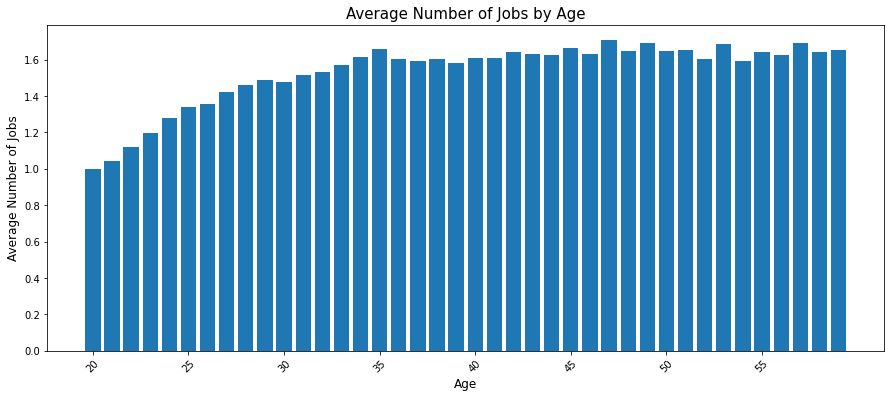

In [0]:
# number of jobs changed until 2022 per age
age_job_hist = {i: []  for i in range(20, 60)}
for s in X:
    if s[0] == 2022:
        if s[1] not in [i for i in range(18, 60)]:
            continue
        if s[7] == 0:
            continue
        age_job_hist[s[1]].append(s[7])

xs = [str(i) for i in range(20, 60)]
vals = [np.mean(age_job_hist[k]) for k in range(20,60)]

plt.figure(figsize=(15, 6))
plt.bar(xs, vals)

plt.title("Average Number of Jobs by Age", fontsize=15)
plt.ylabel("Average Number of Jobs", fontsize=12)
plt.xlabel("Age", fontsize=12)
plt.xticks(rotation=45)
plt.xticks(xs[::5])
plt.show()

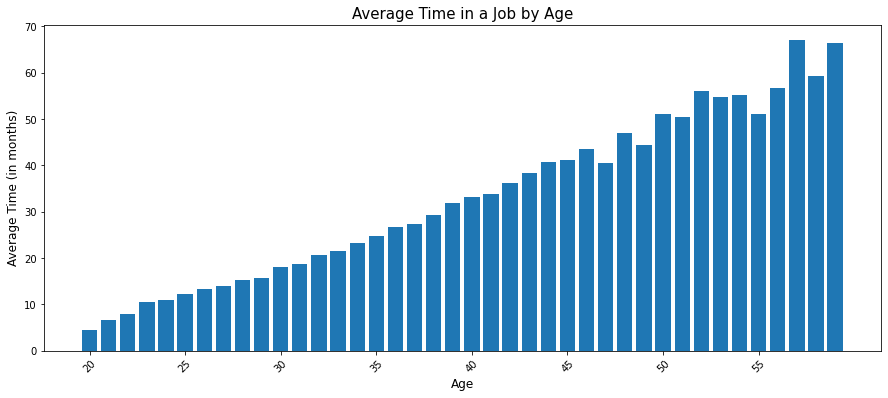

In [0]:
# average time spent in previous jobs until 2022 per age
age_job_hist = {i: []  for i in range(20, 60)}
for s in X:
    if s[0] == 2022:
        if s[1] not in [i for i in range(18, 60)]:
            continue
        if s[8] == 0:
            continue
        age_job_hist[s[1]].append(s[8])

xs = [str(i) for i in range(20, 60)]
vals = [np.mean(age_job_hist[k]) for k in range(20,60)]

plt.figure(figsize=(15, 6))
plt.bar(xs, vals)

plt.title("Average Time in a Job by Age", fontsize=15)
plt.ylabel("Average Time (in months)", fontsize=12)
plt.xlabel("Age", fontsize=12)
plt.xticks(rotation=45)
plt.xticks(xs[::5])
plt.show()

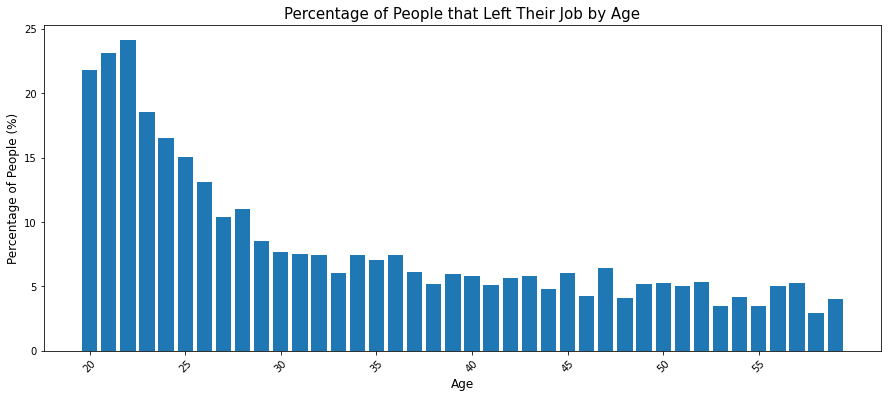

In [0]:
# percentage of people that left their job in the year 2022 per age
age_job_hist = {i: [0, 1]  for i in range(20, 60)}
for s in X:
    if s[0] != 2022 or s[1] not in [i for i in range(20, 60)]:
        continue
    if s[-1] == 1: # change job
        age_job_hist[s[1]][0] += 1
    age_job_hist[s[1]][1] += 1

xs = [str(i) for i in range(20, 60)]
vals = [(age_job_hist[k][0] / age_job_hist[k][1]) * 100 for k in range(20,60)]

plt.figure(figsize=(15, 6))
plt.bar(xs, vals)

plt.title("Percentage of People that Left Their Job by Age", fontsize=15)
plt.ylabel("Percentage of People (%)", fontsize=12)
plt.xlabel("Age", fontsize=12)
plt.xticks(rotation=45)
plt.xticks(xs[::5])
plt.show()